In [ ]:
# STEP 1: Install dependencies
!pip install torch torchvision matplotlib tqdm numpy pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import os

def count_jpg_files(directory):
    count = 0
    for filename in os.listdir(directory):
        if filename.lower().endswith('.jpg'):
            count += 1
    return count

directory_path = '/content/sample_data/CHAOS/Train'
jpg_count = count_jpg_files(directory_path)
print(f"Number of .jpg files: {jpg_count}")


Number of .jpg files: 300


In [ ]:
#Import the libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# ========== Dataset ==========
class CTImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(), # Smart Augmentation
    transforms.Normalize((0.5,), (0.5,))
])

data_path = "/content/sample_data/CHAOS/Train"
dataset = CTImageDataset(image_dir=data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
import torch.nn.functional as F

class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, norm=True, dropout=False):
        super().__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        ]
        if norm:
            layers.append(nn.InstanceNorm2d(out_channels))
        if dropout:
            layers.append(nn.Dropout(0.2))
        layers += [
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        ]
        if norm:
            layers.append(nn.InstanceNorm2d(out_channels))
        if dropout:
            layers.append(nn.Dropout(0.2))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, base_channels=64):
        super().__init__()
        # Encoder
        self.enc1 = UNetBlock(in_channels, base_channels)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = UNetBlock(base_channels, base_channels * 2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = UNetBlock(base_channels * 2, base_channels * 4)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = UNetBlock(base_channels * 4, base_channels * 8)

        # Decoder
        self.up3 = nn.ConvTranspose2d(base_channels * 8, base_channels * 4, 2, stride=2)
        self.dec3 = UNetBlock(base_channels * 8, base_channels * 4)
        self.up2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 2, stride=2)
        self.dec2 = UNetBlock(base_channels * 4, base_channels * 2)
        self.up1 = nn.ConvTranspose2d(base_channels * 2, base_channels, 2, stride=2)
        self.dec1 = UNetBlock(base_channels * 2, base_channels)

        # Final layer
        self.final = nn.Sequential(
            nn.Conv2d(base_channels, in_channels, 1),
            nn.Tanh()
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        b = self.bottleneck(self.pool3(e3))

        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.final(d1)

In [ ]:
# ========== Discriminator ==========
class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.InstanceNorm2d(128),#nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.InstanceNorm2d(128),#nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# ========== Diffusion Scheduler ==========
class DiffusionScheduler:
    def __init__(self, timesteps=1000):
        self.timesteps = timesteps
        self.betas = self._cosine_beta_schedule(timesteps)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = np.cumprod(self.alphas)
        self.sqrt_alphas_cumprod = torch.tensor(np.sqrt(self.alphas_cumprod), dtype=torch.float32)
        self.sqrt_one_minus_alphas_cumprod = torch.tensor(np.sqrt(1 - self.alphas_cumprod), dtype=torch.float32)

    def _cosine_beta_schedule(self, timesteps, s=0.008):
        steps = timesteps + 1
        x = np.linspace(0, timesteps, steps)
        alphas_cumprod = np.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return np.clip(betas, 0.0001, 0.9999)

    def add_noise(self, x, t):
        noise = torch.randn_like(x)
        t = t.long()

        # Move scheduler tensors to the same device as input `x`
        self.sqrt_alphas_cumprod = self.sqrt_alphas_cumprod.to(x.device)
        self.sqrt_one_minus_alphas_cumprod = self.sqrt_one_minus_alphas_cumprod.to(x.device)

        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t][:, None, None, None]
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None]

        return sqrt_alphas_cumprod_t * x + sqrt_one_minus_alphas_cumprod_t * noise, noise

In [ ]:
# ========== Training ==========
def train(generator, discriminator, dataloader, scheduler, device, num_epochs):
    gen_opt = optim.Adam(generator.parameters(), lr=1e-4)
    disc_opt = optim.Adam(discriminator.parameters(), lr=1e-4)

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()

    max_timesteps = scheduler.timesteps

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # Gradually increase noise level during training
        t_max = int(np.interp(epoch, [0, num_epochs * 0.5], [300, max_timesteps]))
        t_min = 0

        for real in tqdm(dataloader):
            real = real.to(device)
            bs = real.size(0)

            # Curriculum sampling
            t = torch.randint(t_min, t_max, (bs,), device=device)
            noised, noise = scheduler.add_noise(real, t)

            pred_noise = generator(noised)
            reconstructed = noised - pred_noise

            # === Discriminator ===
            disc_real = discriminator(real)
            disc_fake = discriminator(reconstructed.detach())
            real_labels = torch.ones_like(disc_real)
            fake_labels = torch.zeros_like(disc_fake)

            loss_disc = bce_loss(disc_real, real_labels) + bce_loss(disc_fake, fake_labels)
            disc_opt.zero_grad()
            loss_disc.backward()
            disc_opt.step()

            # === Generator ===
            disc_fake = discriminator(reconstructed)
            loss_gen = mse_loss(pred_noise, noise) + 0.05 * bce_loss(disc_fake, real_labels)
            gen_opt.zero_grad()
            loss_gen.backward()
            gen_opt.step()

        print(f"Loss Gen: {loss_gen.item():.4f}, Loss Disc: {loss_disc.item():.4f}")

        # Visualize results during training
        #if (epoch + 1) % 10 == 0:
            #visualize(generator, scheduler, dataloader, device, epoch=epoch, total_epochs=num_epochs)

    # Save model after training
    torch.save(generator.state_dict(), "diffusion_gan_generator.pth")
    print("Model saved as 'diffusion_gan_generator.pth'.")

In [ ]:
# ========== Visualization ==========
def visualize(generator, scheduler, dataloader, device, epoch=None, total_epochs=100):
    generator.eval()
    with torch.no_grad():
        real = next(iter(dataloader)).to(device)
        bs = real.size(0)

        # Use curriculum-based t_max if epoch is provided
        if epoch is not None:
            t_max = int(np.interp(epoch, [0, total_epochs * 0.5], [300, scheduler.timesteps]))
        else:
            t_max = 700  # default fallback
        t_min = 0

        t = torch.randint(t_min, t_max, (bs,), device=device)

        noised, _ = scheduler.add_noise(real, t)
        pred_noise = generator(noised)
        reconstructed = noised - pred_noise

        for i in range(1):  # show only 1 sample
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(real[i].cpu().squeeze(), cmap='gray')
            axs[0].set_title("Original")
            axs[1].imshow(noised[i].cpu().squeeze(), cmap='gray')
            axs[1].set_title("Noised (t = {})".format(t[i].item()))
            axs[2].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
            axs[2].set_title("Generated")
            for ax in axs:
                ax.axis("off")
            plt.tight_layout()
            plt.show()
    generator.train()


Epoch 1/30


  0%|          | 0/19 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/instancenorm.py:115: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(
100%|██████████| 19/19 [00:05<00:00,  3.47it/s]


Loss Gen: 0.3413, Loss Disc: 1.1991

Epoch 2/30


100%|██████████| 19/19 [00:03<00:00,  5.32it/s]


Loss Gen: 0.3328, Loss Disc: 1.1146

Epoch 3/30


100%|██████████| 19/19 [00:03<00:00,  5.29it/s]


Loss Gen: 0.3370, Loss Disc: 1.0600

Epoch 4/30


100%|██████████| 19/19 [00:03<00:00,  5.26it/s]


Loss Gen: 0.2871, Loss Disc: 1.0230

Epoch 5/30


100%|██████████| 19/19 [00:03<00:00,  5.25it/s]


Loss Gen: 0.2705, Loss Disc: 0.9865

Epoch 6/30


100%|██████████| 19/19 [00:03<00:00,  5.25it/s]


Loss Gen: 0.2770, Loss Disc: 0.9502

Epoch 7/30


100%|██████████| 19/19 [00:03<00:00,  5.22it/s]


Loss Gen: 0.2720, Loss Disc: 0.9117

Epoch 8/30


100%|██████████| 19/19 [00:03<00:00,  5.24it/s]


Loss Gen: 0.2487, Loss Disc: 0.8898

Epoch 9/30


100%|██████████| 19/19 [00:03<00:00,  5.21it/s]


Loss Gen: 0.2675, Loss Disc: 0.8578

Epoch 10/30


100%|██████████| 19/19 [00:03<00:00,  5.12it/s]


Loss Gen: 0.3067, Loss Disc: 0.8413

Epoch 11/30


100%|██████████| 19/19 [00:03<00:00,  5.19it/s]


Loss Gen: 0.2428, Loss Disc: 0.7950

Epoch 12/30


100%|██████████| 19/19 [00:03<00:00,  5.14it/s]


Loss Gen: 0.2664, Loss Disc: 0.7670

Epoch 13/30


100%|██████████| 19/19 [00:03<00:00,  5.12it/s]


Loss Gen: 0.2547, Loss Disc: 0.7358

Epoch 14/30


100%|██████████| 19/19 [00:03<00:00,  5.14it/s]


Loss Gen: 0.2482, Loss Disc: 0.7016

Epoch 15/30


100%|██████████| 19/19 [00:03<00:00,  5.14it/s]


Loss Gen: 0.2482, Loss Disc: 0.6634

Epoch 16/30


100%|██████████| 19/19 [00:03<00:00,  4.92it/s]


Loss Gen: 0.2523, Loss Disc: 0.6485

Epoch 17/30


100%|██████████| 19/19 [00:03<00:00,  5.09it/s]


Loss Gen: 0.2510, Loss Disc: 0.6296

Epoch 18/30


100%|██████████| 19/19 [00:03<00:00,  5.07it/s]


Loss Gen: 0.2473, Loss Disc: 0.5953

Epoch 19/30


100%|██████████| 19/19 [00:03<00:00,  5.06it/s]


Loss Gen: 0.2469, Loss Disc: 0.5678

Epoch 20/30


100%|██████████| 19/19 [00:03<00:00,  5.04it/s]


Loss Gen: 0.2606, Loss Disc: 0.5428

Epoch 21/30


100%|██████████| 19/19 [00:03<00:00,  5.02it/s]


Loss Gen: 0.2974, Loss Disc: 0.5193

Epoch 22/30


100%|██████████| 19/19 [00:03<00:00,  5.00it/s]


Loss Gen: 0.2465, Loss Disc: 0.5307

Epoch 23/30


100%|██████████| 19/19 [00:03<00:00,  4.98it/s]


Loss Gen: 0.2560, Loss Disc: 0.4864

Epoch 24/30


100%|██████████| 19/19 [00:03<00:00,  4.99it/s]


Loss Gen: 0.2696, Loss Disc: 0.4386

Epoch 25/30


100%|██████████| 19/19 [00:04<00:00,  4.60it/s]


Loss Gen: 0.2511, Loss Disc: 0.4449

Epoch 26/30


100%|██████████| 19/19 [00:03<00:00,  5.02it/s]


Loss Gen: 0.2563, Loss Disc: 0.4434

Epoch 27/30


100%|██████████| 19/19 [00:03<00:00,  5.03it/s]


Loss Gen: 0.2805, Loss Disc: 0.4171

Epoch 28/30


100%|██████████| 19/19 [00:03<00:00,  5.04it/s]


Loss Gen: 0.2806, Loss Disc: 0.3960

Epoch 29/30


100%|██████████| 19/19 [00:03<00:00,  5.06it/s]


Loss Gen: 0.2525, Loss Disc: 0.3907

Epoch 30/30


100%|██████████| 19/19 [00:03<00:00,  5.07it/s]


Loss Gen: 0.2665, Loss Disc: 0.3580
Model saved as 'diffusion_gan_generator.pth'.


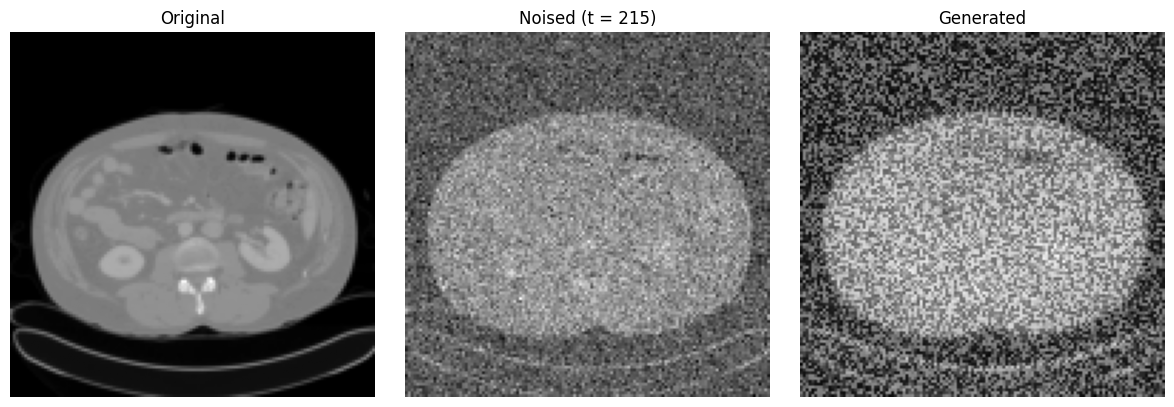

In [ ]:
# ========== Run Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = UNetGenerator().to(device)
discriminator = Discriminator().to(device)
scheduler = DiffusionScheduler(timesteps=1000)

train(generator, discriminator, dataloader, scheduler, device, num_epochs=30)
visualize(generator, scheduler, dataloader, device)

In [ ]:
def generate_images(generator, scheduler, dataloader, device, num_images=10, save_dir="generated_images"):
    generator.eval()
    os.makedirs(save_dir, exist_ok=True)

    count = 0
    with torch.no_grad():
        for real in dataloader:
            real = real.to(device)
            bs = real.size(0)

            # Sample random timesteps
            t = torch.randint(0, scheduler.timesteps, (bs,), device=device)
            noised, _ = scheduler.add_noise(real, t)

            # Predict noise and reconstruct
            pred_noise = generator(noised)
            reconstructed = noised - pred_noise

            # Save images
            for i in range(bs):
                if count >= num_images:
                    return
                img = reconstructed[i].cpu().squeeze().clamp(-1, 1) * 0.5 + 0.5  # unnormalize to [0, 1]
                img = transforms.ToPILImage()(img)
                img.save(os.path.join(save_dir, f"synthetic_{count:03d}.png"))
                count += 1

generate_images(generator, scheduler, dataloader, device, num_images=10, save_dir="/content/sample_data/Synthetic_CT")

In [ ]:
# Step 2: Zip the folder containing synthetic images
!zip -r synthetic_ct.zip /content/sample_data/Synthetic_CT/

# Step 3: Move the zip file to your Google Drive 'CHAOS' folder
!mv synthetic_ct.zip /content/drive/MyDrive/CHAOS/

updating: content/sample_data/Synthetic_CT/ (stored 0%)
updating: content/sample_data/Synthetic_CT/synthetic_006.png (stored 0%)
updating: content/sample_data/Synthetic_CT/synthetic_000.png (stored 0%)
updating: content/sample_data/Synthetic_CT/synthetic_007.png (stored 0%)
updating: content/sample_data/Synthetic_CT/synthetic_003.png (stored 0%)
updating: content/sample_data/Synthetic_CT/synthetic_004.png (stored 0%)
updating: content/sample_data/Synthetic_CT/synthetic_001.png (stored 0%)
updating: content/sample_data/Synthetic_CT/synthetic_005.png (stored 0%)
updating: content/sample_data/Synthetic_CT/synthetic_009.png (stored 0%)
updating: content/sample_data/Synthetic_CT/synthetic_002.png (stored 0%)
updating: content/sample_data/Synthetic_CT/synthetic_008.png (stored 0%)
